In [1]:
# train_dir = '../data/stretched/train'
# # test_dir = '../data/stretched/test'
# validation_dir = '../data/stretched/val'

img_shape = (96, 96, 3)
conv_out_shape = (3, 3, 512)
nr_of_labels = 7
nr_of_train_imgs = 28709
nr_of_val_imgs = 3589
train_batch_size = 1511
val_batch_size = 97
import numpy as np

def extract_features(sample_count, batch_size, imgs, labels):
    from keras.applications import VGG16
    from keras.preprocessing.image import ImageDataGenerator
    from keras.applications.vgg16 import preprocess_input

    conv_base = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape= img_shape)

    datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, height_shift_range=0.1,
                                 width_shift_range=0.1, zoom_range=0.1, rotation_range=10, shear_range=0.1)
    generator = datagen.flow(imgs, labels, batch_size=batch_size)
    features = np.zeros(shape=((sample_count,) + conv_out_shape)).astype('float32')
    labels = np.zeros(shape=(sample_count, nr_of_labels)).astype('uint8')

    for i, (inputs_batch, label_batch) in enumerate(generator):
        if i * batch_size >= sample_count:
            break
        print(f'Step: {(i+1)*batch_size}', end='\r')
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = label_batch
    return features, labels

def get_model():
    from keras.models import Sequential
    from keras.layers import Dense, Dropout

    model = Sequential()
    # model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model

def train():
    import operator
    import functools
    from simplier_keras.default_callbacks import get_default_callbacks


    model = get_model()
    all_hist = []
    shp = functools.reduce(operator.mul, conv_out_shape, 1)
    print(shp)

    images = np.load('../data/images.npz')

    callbacks = get_default_callbacks('vgg16_calssifier')

    for step in range(50):
        print(f'\n\nStep: {step} \n\n')
        train_features, train_labels = extract_features(nr_of_train_imgs, train_batch_size,
                                                        images['train_images'], images['train_labels'])
        val_features, val_labels = extract_features(nr_of_val_imgs, val_batch_size,
                                                    images['val_images'], images['val_labels'])


        train_features = np.reshape(train_features, (nr_of_train_imgs, shp))
        val_features = np.reshape(val_features, (nr_of_val_imgs, shp))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        hist = model.fit(train_features, train_labels, batch_size=128, epochs=100, validation_data=(val_features, val_labels),
                     callbacks=callbacks, verbose=2, steps_per_epoch=nr_of_train_imgs/train_batch_size)

        all_hist.append(hist.history)
    return all_hist

history = train()

4608
Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Processing from 3492 to 3589

Step: 0 


Step: 194Step: 388Step: 582Step: 776Step: 970Step: 1164Step: 1358Step: 1552Step: 1746Step: 1940Step: 2134Step: 2328Step: 2522Step: 2716Step: 2910Step: 3104Step: 3298Step: 3492Epoch 1/100
19/19 - 1s - loss: 9.7281 - acc: 0.2241 - val_loss: 2.4260 - val_acc: 0.2736

Epoch 00001: val_acc improved from -inf to 0.27361, saving model to ../models/external_fast_model.h5
Epoch 2/100
19/19 - 0s - loss: 3.2984 - acc: 0.2463 - val_loss: 1.8707 - val_acc: 0.2942

Epoch 00002: val_acc improved from 0.27361 to 0.29423, saving model to ../models/external_fast_model.h5
Epoch 3/100
19/19 - 0s - loss: 2.3410 - acc: 0.2656 - val_loss: 1.7816 - val_acc: 0.2836

Epoch 00003: val_acc did not improve from 0.29423
Epoch 4/100
19/19 - 0s - loss: 2.2008 - acc: 0.2459 - val_loss: 1.7459 - val_acc: 0.3040

Epoch 00004: val_acc improved from 0.29423 to 0.30398, saving model to ../model

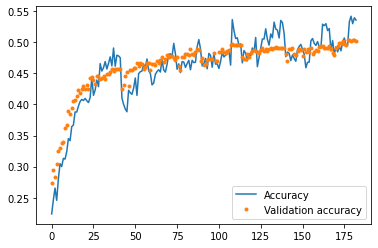

In [4]:
import matplotlib.pyplot as plt

acc_history = [hist["acc"] for hist in history]
val_history = [hist["val_acc"] for hist in history]
acc_history = [x for i in acc_history for x in i]
val_history = [x for i in val_history for x in i]
epochs = range(len(acc_history))
plt.plot(epochs, acc_history, label='Accuracy')
plt.plot(epochs, val_history, '.', label='Validation accuracy')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(epochs, history['loss'], label='loss')
# plt.plot(epochs, history['val_loss'], label='validation_loss')